In [1]:
import torch
from torch.utils.data import DataLoader
from dynamic_model.dataset import load_dataset
from dynamic_model.dataset import DynamicsModelDataset
from dynamic_model.model import DynamicsLookAheadModel
from dynamic_model.train import train_model
from dynamic_model.eval import eval_model

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Using Device: {device}")
torch.backends.cudnn.benchmark = True


Using Device: cuda:0


## Load Dataset

In [3]:
dataset_input_key = 'merged_input'
dataset_output_key = 'merged_output'
dataset_file_path = 'tmp/ib-out/ib-samples-la.npy'


batch_size = 6000
pin_memory = True
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0,
          'drop_last':True,
          'pin_memory':pin_memory}



train_dataset, val_dataset = load_dataset(file_path=dataset_file_path, input_key=dataset_input_key, output_key= dataset_output_key, dataset_class=DynamicsModelDataset, normalize=False, device="cpu")
train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)


torch.Size([658000, 59, 9])
torch.Size([658000, 30, 6])
torch.Size([282000, 59, 9])
torch.Size([282000, 30, 6])


## Define model

In [4]:
model_path = 'dynamic_model/model'
num_of_features = train_dataset.get_features_size()
seq_len = train_dataset.get_seq_len()
hidden_size = 16
out_size = train_dataset.get_output_feature_size()
look_ahead = train_dataset.get_look_ahead_size()
n_layers = 6
dropout_p = 0.3
print(seq_len)
model = DynamicsLookAheadModel(features=num_of_features,hidden_size=hidden_size,out_size=out_size, batch_size=batch_size, seq_len=seq_len, n_layers=n_layers, dropout_p=dropout_p, look_ahead=look_ahead).to(device=device)

30


## Train Model

In [5]:
load_to_gpu = model.is_cuda() and not train_dataset.x.is_cuda
print(load_to_gpu)
train_model(model=model, train_loader=train_loader, test_loader=val_loader, n_epochs=300, learning_rate=1e-4, load_to_gpu=load_to_gpu)

True
Untrained test
--------
Actual: tensor([ 70.0000,  53.1673,  80.4321,   5.9031,   6.6788, 291.3542],
       device='cuda:0')
Predicted: tensor([-0.1626, -0.1353, -0.2477,  0.0998, -0.1489,  0.2138], device='cuda:0')
Test loss: 13668.050843583776

Epoch 0
---------
Train loss: 13567.04056766055
Actual: tensor([ 70.0000,  90.4082,  15.4282,  45.6669,  27.1099, 196.5162],
       device='cuda:0')
Predicted: tensor([-0.1255, -0.0968, -0.2357,  0.1262, -0.1001,  0.3073], device='cuda:0')
Test loss: 13659.081948138299
Epoch time: epoch_time = 17.382s
Epoch 1
---------
Train loss: 13556.760849698969
Actual: tensor([ 70.0000,  40.6787,  93.5326,  36.3536,   5.4112, 208.5168],
       device='cuda:0')
Predicted: tensor([-0.0690, -0.0310, -0.2011,  0.1339, -0.0361,  0.4519], device='cuda:0')
Test loss: 13645.564390791224
Epoch time: epoch_time = 18.557s
Epoch 2
---------
Train loss: 13545.538399512614
Actual: tensor([ 70.0000,  32.3896,  91.5778,   1.6205,  14.4733, 204.2121],
       device='

## Save Model

In [6]:

torch.save(model.state_dict(), model_path)
torch.cuda.empty_cache()
del model

## Load Model for evaluation

In [5]:
eval_batch_size = 1

model = DynamicsLookAheadModel(features=num_of_features,hidden_size=hidden_size,out_size=out_size, batch_size=eval_batch_size, seq_len=seq_len, n_layers=n_layers, dropout_p=dropout_p, look_ahead=look_ahead)

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

torch.Size([1, 59, 9])
tensor([[[ 57.3338,  49.5875,  52.6046,  46.5048,  45.5002, 166.7149],
         [ 57.3338,  49.5875,  52.6046,  46.5048,  45.5002, 166.7149],
         [ 57.3338,  49.5875,  52.6046,  46.5048,  45.5002, 166.7149],
         [ 57.3338,  49.5875,  52.6046,  46.5048,  45.5002, 166.7149],
         [ 57.3338,  49.5875,  52.6046,  46.5048,  45.5002, 166.7149],
         [ 53.8608,  45.7378,  46.8693,  44.1192,  45.3219, 145.5177],
         [ 53.8608,  45.7378,  46.8693,  44.1192,  45.3219, 145.5177],
         [ 50.7194,  43.4143,  45.8505,  41.4652,  39.3419, 157.9791],
         [ 51.5389,  46.1394,  51.5178,  41.4379,  35.2063, 179.5381],
         [ 51.5389,  46.1394,  51.5178,  41.4379,  35.2063, 179.5381],
         [ 60.0779,  52.7965,  57.6377,  48.4575,  43.8967, 195.7533],
         [ 60.0779,  52.7965,  57.6377,  48.4575,  43.8967, 195.7533],
         [ 60.0779,  52.7965,  57.6377,  48.4575,  43.8967, 195.7533],
         [ 60.0779,  52.7965,  57.6377,  48.4575,  43.

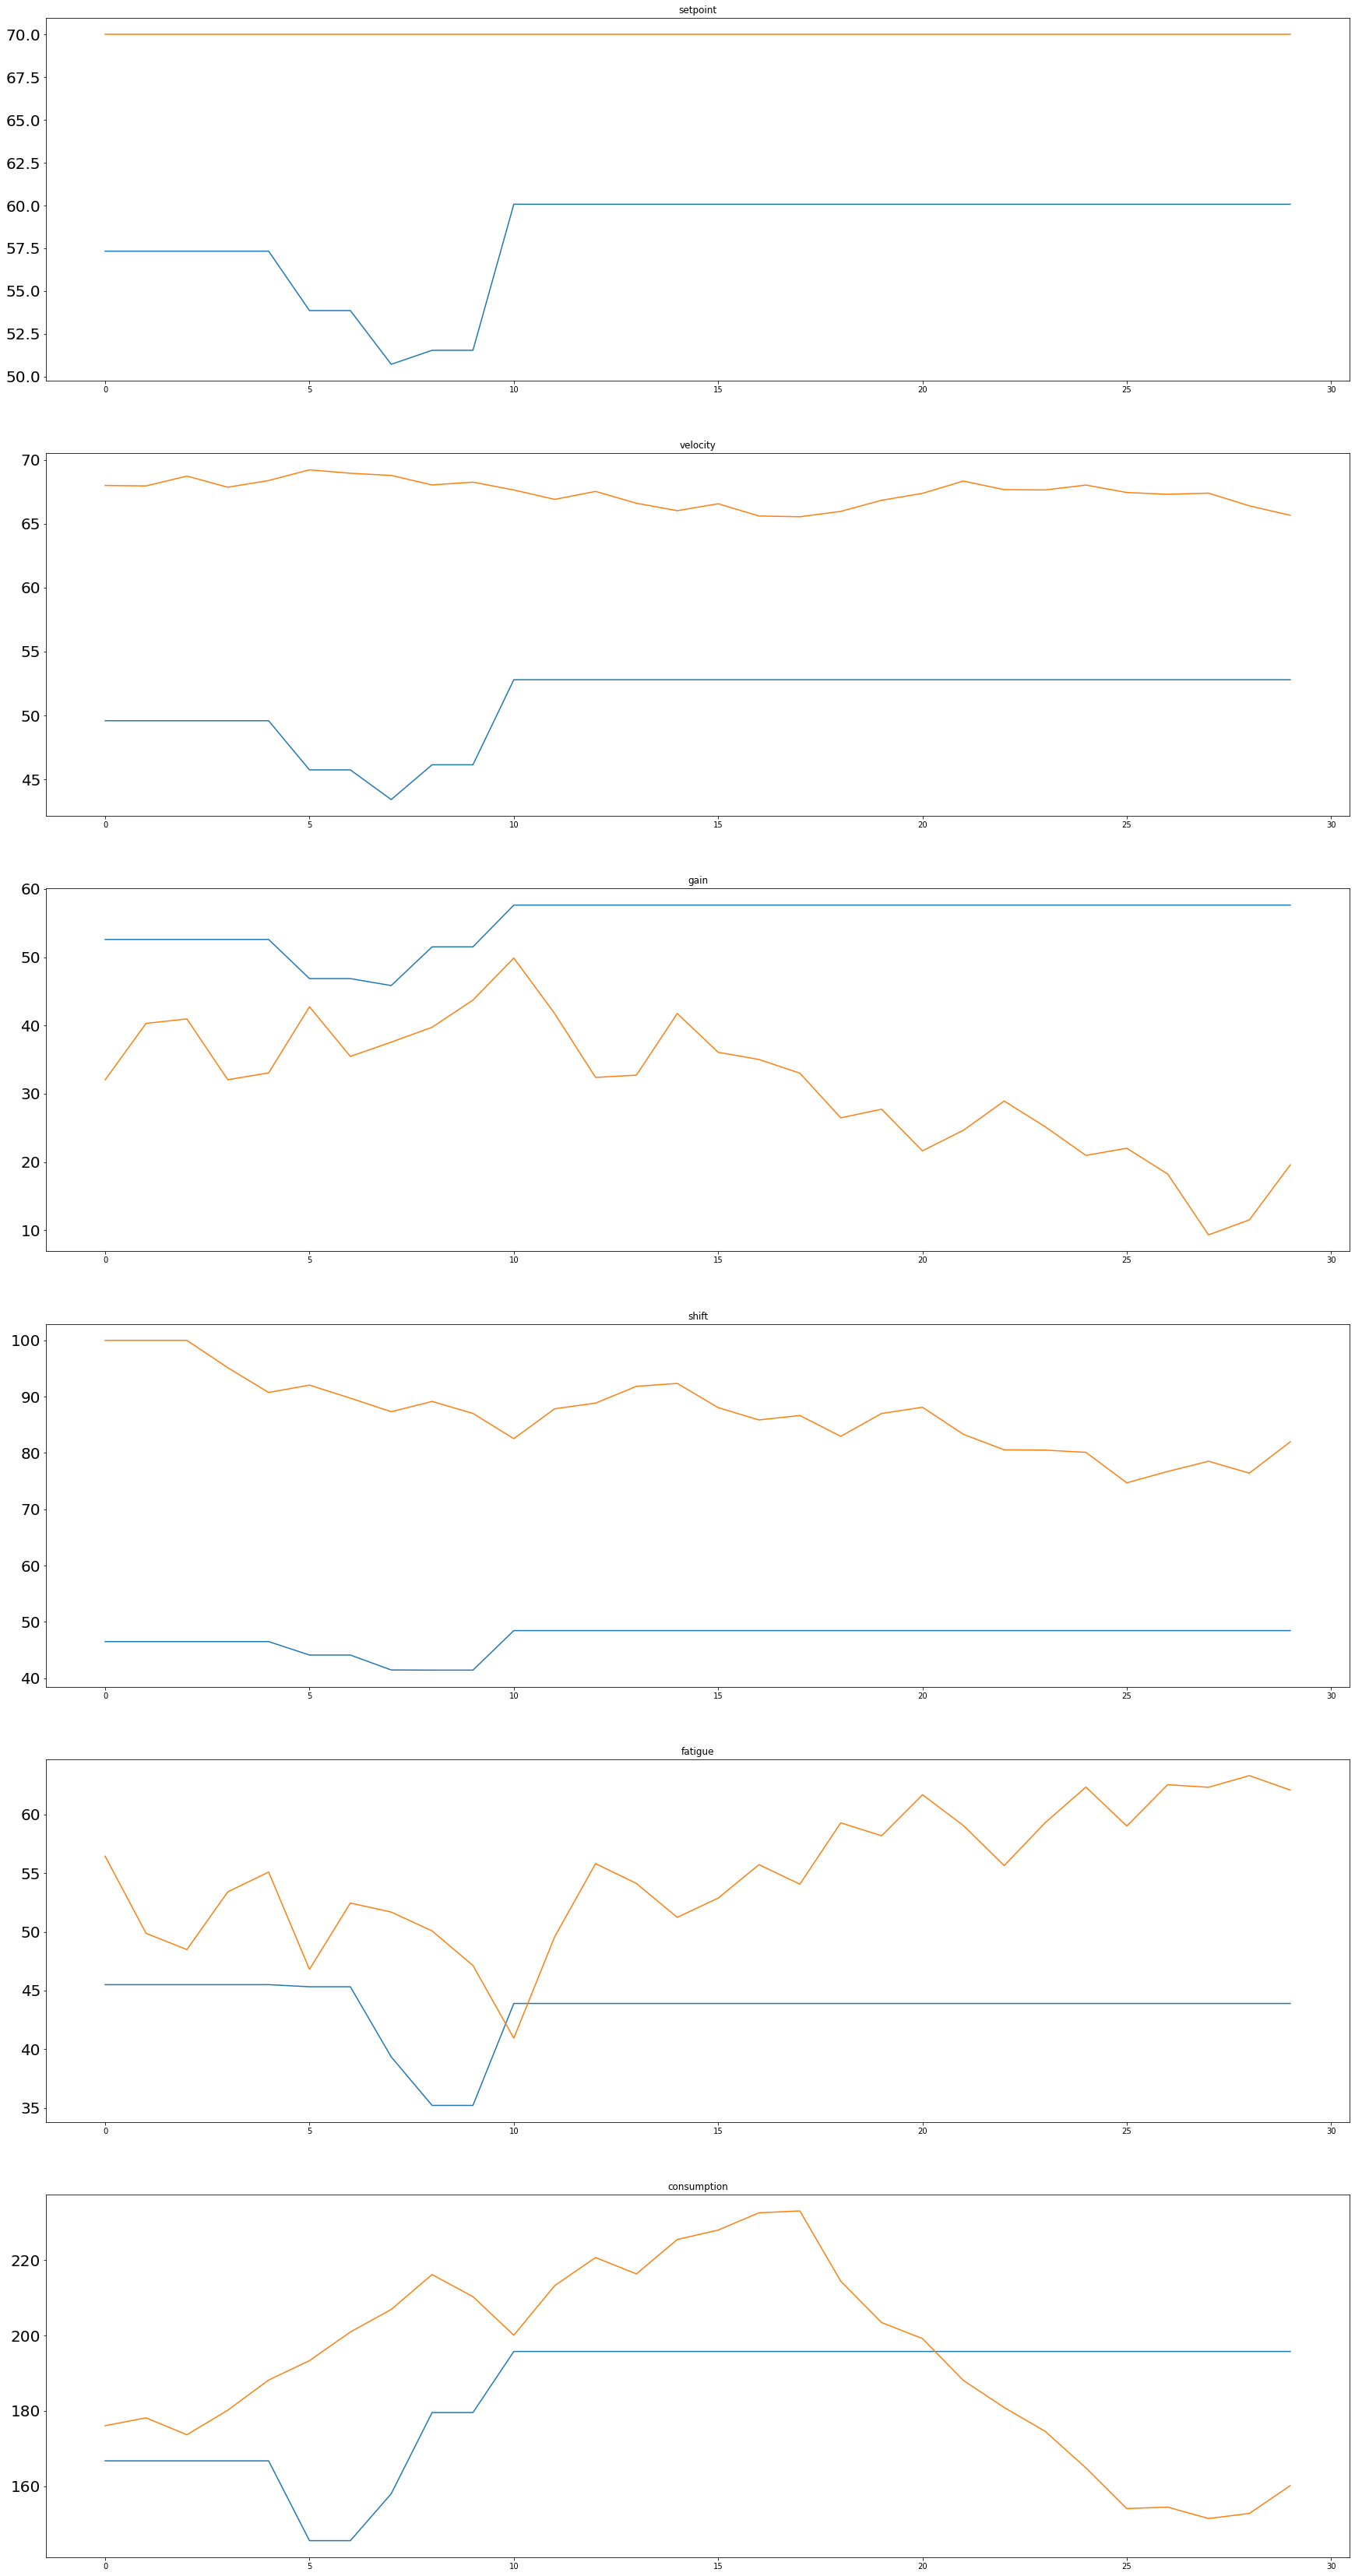

In [8]:
eval_model(model,x=val_dataset.x[888],y=val_dataset.y[888])